In [1]:
import numpy as np
from matplotlib import colors
from matplotlib import cm
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.gridspec import GridSpec
import matplotlib.ticker as mticker
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pickle
import signac as sg
from scipy.special import gamma
import copy as copy
import scipy
from global_functions import adjustmaps
import h5py
from scipy.interpolate import make_lsq_spline
from itertools import product
import os

# Define/load things non-specific to a given set of results
metric = 'lambda_s'
Aeff = 7.29
t_final = 300
ncell_tot = 87_993
c = 1.42
with sg.H5Store('shared_data.h5').open(mode='r') as sd:
    b_vec = np.array(sd['b_vec'])
tau_vec = b_vec * gamma(1+1/c)
tauc_methods = ["flat"]
results_pre = 'gte_thresh' 

# Update global plotting parameters
rc('axes', labelsize=21)  # Font size for x and y labels
rc('axes', titlesize=16)
rc('xtick', labelsize=19)  # Font size for x-axis tick labels
rc('ytick', labelsize=19)  # Font size for y-axis tick labels
rc('lines', markersize=15)  
rc('lines', linewidth=5.5)
rc('legend', fontsize=19)
rc('font', family='sans-serif')
rc('font', serif=['Computer Modern Sans Serif'] + plt.rcParams['font.serif'])
rc('font', weight='light')
histlw = 5.5
cbar_lpad = 30
dpi = 50
# dpi = 200

# Function to read in things specific to given results as global variables
def set_globals(results_pre):
    if metric == 'lambda_s':
        globals()['metric_lab'] = r'$S$'
        globals()['rob_metric_lab'] = r'$S^*$'
        globals()['mean_metric_lab'] = r'$\bar{\lambda}(\tau)$'
    if metric == 'P_s':
        globals()['metric_lab'] = r'$S_{meta}$'
        globals()['rob_metric_lab'] = r'$\S_{meta}^*$'
        globals()['mean_metric_lab'] = r'$<P_s>$'
    if metric == 's':
        globals()['metric_lab'] = r'$s_{meta}$'
        globals()['rob_metric_lab'] = r'$\s_{meta}^*$'
        globals()['mean_metric_lab'] = r'$<s>$'
    globals()['fn_prefix'] = f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
    globals()['fig_prefix'] = f"{results_pre}/figs/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/"
    # globals()['fig_prefix'] = os.path.join('/','Volumes', 'Macintosh HD', 'Users', 'patrick', 
    #                                        'Google Drive', 'My Drive', 'Research', 'Regan', 'Figs/')

    # Load things saved specific to these results
    globals()['metric_all'] = np.load(f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/metric_{metric}/metric_all.npy")
    globals()['tau_all'] = np.load(f"{results_pre}/data/Aeff_{Aeff}/tfinal_{t_final}/tau_all.npy")
    globals()['C_vec'] = np.load(fn_prefix + "C_vec.npy")
    globals()['C_i_vec'] = np.arange(len(C_vec))[::2]
    globals()['ncell_vec'] = np.load(fn_prefix + "ncell_vec.npy")
    globals()['slice_left_all'] = np.load(fn_prefix + "slice_left_all.npy")
    eps_axes = {}
    with h5py.File(fn_prefix + "eps_axes.h5", "r") as handle:
        for key in handle.keys():
            eps_axes.update({key: handle[key][()]})
    globals()['eps_axes'] = eps_axes

# Read in maps and convert fdm to tau, used by multiple plots below
ul_coord = [1500, 2800]
lr_coord = [2723, 3905]
usecols = np.arange(ul_coord[0],lr_coord[0])
sdmfn = "../shared_maps/SDM_1995.asc"
sdm = np.loadtxt(sdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
fdmfn = '../shared_maps/FDE_current_allregions.asc'
fdm = np.loadtxt(fdmfn,skiprows=6+ul_coord[1],
                         max_rows=lr_coord[1], usecols=usecols)
sdm, fdm = adjustmaps([sdm, fdm])
delta_t = 30
b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)
tau_raster = b_raster * gamma(1+1/c)
maps_filt = (sdm > 0) & (fdm > 0)
tau_flat = tau_raster[maps_filt] 
mapindices = np.argwhere(maps_filt)
tau_argsort = np.argsort(tau_flat)
tau_sorted = tau_flat[tau_argsort]

/var/folders/jd/fczwycqx1lxch_x4svbjh6680000gn/T/ipykernel_33983/3898581028.py:92: RuntimeWarning: divide by zero encountered in divide
  b_raster = delta_t / np.power(-np.log(1-fdm), 1/c)


In [2]:
set_globals(results_pre)
x_all = np.load(fn_prefix + '/x_all.npy')
meta_metric_all = np.load(fn_prefix + '/meta_metric_all.npy')
meta_metric_all = meta_metric_all[:,0]

# Create a filter for the baseline scenario
zero_eps_mask = np.all(x_all[:, 3:] == 0, axis=1)

maxrob = np.load(fn_prefix + "maxrob.npy")
argmaxrob = np.load(fn_prefix + "argmaxrob.npy")
rob_thresh_vec = np.load(fn_prefix + "rob_thresh_vec.npy")
rob_all = np.load(fn_prefix + "rob_all.npy")

### Looking at raw samples

In [ ]:
# q_vec = np.arange(0.1, 0.9, 0.1)
q_vec = np.arange(0.05, 0.85, 0.05)

# results = {}
keys = ['delta_range', 'delta_median', 'median', 'range', 'delta_n', 'delta_l', 'n', 'l',
        'delta_taul', 'delta_tauh']
results = {key: np.full((C_vec.size, q_vec.size), np.nan) for key in keys}
results['n_baseline'] = np.full(C_vec.size, np.nan)
results['l_baseline'] = np.full(C_vec.size, np.nan)

for C_i, C in enumerate(C_vec):
    for q_i, q in enumerate(q_vec):
        if q_i == 0:
            # First get optimal tau slice stats from optimal decisions under baseline
            zeroeps_filt = np.all(x_all[:, 3:] == 0, axis=1)
            _filt = zeroeps_filt & (x_all[:,0] == C)
            argmax = np.nanargmax(meta_metric_all[_filt])
            S_opt_baseline = meta_metric_all[_filt][argmax]
            n_opt_baseline, sl_opt_baseline = x_all[_filt,:][argmax][1:3].astype(int)
            tau_slice_baseline = tau_sorted[sl_opt_baseline:sl_opt_baseline+n_opt_baseline]
            range_baseline = tau_slice_baseline.max() - tau_slice_baseline.min()
            median_baseline = np.median(tau_slice_baseline)
            
            results['n_baseline'][C_i] = n_opt_baseline
            results['l_baseline'][C_i] = sl_opt_baseline

        # Now get the same statistics for (1-q) * optimal S baseline
        Sstar_rob_i = np.argmin(np.abs(rob_thresh_vec - ((1 - q) * S_opt_baseline)) )
        n_opt_rob = ncell_vec[int(argmaxrob[Sstar_rob_i, C_i][0])]
        sl_opt_rob = slice_left_all[int(argmaxrob[Sstar_rob_i, C_i][1])]
        tau_slice_rob = tau_sorted[sl_opt_rob:sl_opt_rob+n_opt_rob]
        range_rob = tau_slice_rob.max() - tau_slice_rob.min()
        median_rob = np.median(tau_slice_rob)

        results['delta_median'][C_i, q_i] = median_rob - median_baseline
        results['delta_range'][C_i, q_i] = range_rob - range_baseline
        results['median'][C_i, q_i] = median_rob
        results['range'][C_i, q_i] = range_rob
        results['delta_n'][C_i, q_i] = n_opt_rob - n_opt_baseline
        results['delta_l'][C_i, q_i] = sl_opt_rob - sl_opt_baseline
        results['n'][C_i, q_i] = n_opt_rob
        results['l'][C_i, q_i] = sl_opt_rob
        results['delta_taul'][C_i][q_i] = tau_sorted[sl_opt_rob] - tau_sorted[sl_opt_baseline]
        results['delta_tauh'][C_i][q_i] = tau_sorted[sl_opt_rob+n_opt_rob] - tau_sorted[sl_opt_baseline+n_opt_baseline]

In [ ]:
results['delta_l+delta_n'] = (results['delta_l'] + results['delta_n']) #/ np.abs(results['delta_n'])

In [ ]:
# Define reference indices for per population tau
tau_indices = np.arange(tau_sorted.size)

# Set the R value we're plotting
C = 9
assert C in C_vec/ncell_tot
C_i = (C_vec/ncell_tot == C).argmax()
# print(f"at baseline for C={C_vec[C_i]} \n optimal n,l = {results['n_baseline'][C_i], results['l_baseline'][C_i]} \n")

for q in [0.05, 0.45, 0.8]:
# for q in [0.5]:
    # Set the S^* value we're plotting
    assert np.any(np.isclose(q_vec, q))
    q_i = np.isclose(q_vec, q).argmax()

    # Get the optimal decision at this {S^*, R} combination
    n_opt = results['n'][C_i, q_i]
    l_opt = results['l'][C_i, q_i]
    # print(f'at q={q}\n optimal n,l = {n_opt, l_opt} \n')

    # Define results vector
    results_vector = np.full(tau_sorted.size, np.nan)
    # where each population is given a number to indicate optimality under:
    #   1 -> baseline condiitons only
    #   2 -> baseline and uncertain conditions (risk aversion)
    #   3 -> uncertain conditions only
    #   0 -> everything else
    
    # Create relevant masks
    baseline_mask = (tau_indices > results['l_baseline'][C_i]) & (tau_indices < results['l_baseline'][C_i] + results['n_baseline'][C_i])
    uncertain_mask = (tau_indices > l_opt) & (tau_indices < l_opt + n_opt)
    baseline_only_mask = baseline_mask & (~uncertain_mask)
    uncertain_only_mask = uncertain_mask & (~baseline_mask)
    both_mask = baseline_mask & uncertain_mask
    neither_mask = ~(baseline_mask | uncertain_mask)
    
    # Use masks to assign values to each population
    results_vector[neither_mask] = 0
    results_vector[baseline_only_mask] = 1
    results_vector[both_mask] = 2
    results_vector[uncertain_only_mask] = 3
    
    # Define colormaping for categories
    custom_colors = ['lightgrey', 'coral', 'orchid', 'blueviolet']
    labels = ['neither', 'baseline only', 'both', 'uncertain only']
    cmap = colors.ListedColormap(custom_colors)
    vmin = 0; vmax = len(custom_colors) - 1
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    
    ### TAU DISTRIBUTION VIZ ###
    
    stack_data = [tau_sorted[results_vector == i] for i in range(len(custom_colors))]
    
    bins = np.linspace(min(tau_flat), 50, 80)
    
    # Plot the stacked histogram
    fig, ax = plt.subplots(figsize=np.array([8,5])*0.75)
    ax.hist(
        stack_data,
        bins=bins,
        stacked=True,
        color=custom_colors,
        label=[labels[i] for i in range(len(custom_colors))]
    )

    ax.set_xlabel(r'$\tau$')
    ax.set_ylabel(r'baseline $\tau$ frequency')
    ax.set_title(f'$q=${q}')
    ax.legend()
    
    ### GEOGRAPHICAL MAP ###

    mapi_sorted = mapindices[tau_argsort].T

    colored_data = np.ones(maps_filt.shape + (4,)) * np.nan #colors in rgba
    colored_data[mapi_sorted[0], mapi_sorted[1]] = cmap(norm(results_vector))
    # Color background
    colored_data[maps_filt == False] = colors.to_rgba('black', alpha=0.3)
    # Crop out border where all nans
    nonzero_indices = np.nonzero(maps_filt)
    row_min, row_max = nonzero_indices[0].min(), nonzero_indices[0].max()
    col_min, col_max = nonzero_indices[1].min(), nonzero_indices[1].max()
    colored_data = colored_data[row_min:row_max + 1, col_min:col_max + 1]

    fig, ax = plt.subplots(figsize=np.array([10,10])*0.7)
    im = ax.imshow(colored_data)#, aspect='auto')
    ax.set_yticks([])
    ax.set_xticks([])

space

In [ ]:
labels = [r'$\Delta(\tau~\text{range})$', r'$\Delta(\tau~\text{median})$', 
          r'$\tau~\text{range}$', r'$\tau~\text{median}$',
          r'$\Delta l + \Delta n$',
          r'$\Delta n$', r'$\Delta l$', r'$n$', r'$l$',
          r'$\Delta \tau_l$', r'$\Delta \tau_h$']
# cmap = copy.copy(cm.RdPu_r)
# cmap = copy.copy(cm.Wistia)
cmap = copy.copy(cm.cool)
vmin = C_vec.min() if (len(C_vec) > 1) else 0
norm = colors.Normalize(vmin=vmin/ncell_tot, vmax=C_vec.max()/ncell_tot)

# Restrict the range of plotting to a desired q value
q_lim = 0.85
q_mask = q_vec <= q_lim 

for key_i, key in enumerate(['delta_range', 'delta_median', 'range', 'median',
                             'delta_l+delta_n', 'delta_n', 'delta_l', 'n', 'l',
                             'delta_taul', 'delta_tauh']):
    fig, ax = plt.subplots(figsize=(9,5))
    
    for C_i, C in enumerate(C_vec):
        # if (C_i) % 2 == 0: continue
        # if C_i < 3: continue
        # if C_i > 3: continue
        # if C_i != len(C_vec) - 1: continue
        # if (C/ncell_tot) < 9: continue
        # if (C/ncell_tot) != 5: continue
        color = cmap(norm(C/ncell_tot))
        ax.scatter(q_vec[q_mask]*100, results[key][C_i, q_mask], marker='o', c=color, alpha=0.8)
        
    # ax.set_xlabel(r'$q$; $S^*=(1-q)\text{max}(S_{baseline})$')
    ax.set_xlabel(r'% of $\text{max}(S_{baseline})$ sacrificed')
    ax.set_ylabel(labels[key_i])
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array(C_vec)
    cbar = fig.colorbar(sm, label=r'$R~/~n_{tot}$', ax=ax)
    
    if key not in ['range', 'median', 'n', 'l']:
        ax.axhline(0, ls='--', lw=1, c='k')
    # ax.set_xlim(0.025,0.525)

### Interpolate $\omega$ to get optimal $\{n,l\}$

In [3]:
# Class to rescale inputs and outputs to [0,1] for numerical stability
# Also store descalers to interpret interpolated values
class Rescaler:
    def __init__(self, mins, maxes):
        """
        mins: vector of minima
        maxes: vector of maxima
        """
        self.mins = mins
        self.maxes = maxes

    def rescale(self, x):
        return (x - self.mins) / (self.maxes - self.mins)
    
    def descale(self, x):
        return (x * (self.maxes - self.mins)) + self.mins

#### 3rd attempt
Create separate interpolators for robustness(n,l) at each S^* values. Could probably get away with using RectBivariateSpline if we assign nan robustness values to zero (or something). Use RegularGridInterpolator for baseline S(n, l) bc we dont need smoothing there. 

In [ ]:
from scipy.interpolate import RectBivariateSpline

C = 9
assert np.any(np.isclose(C_vec/ncell_tot, C))
C_i = np.isclose(C_vec/ncell_tot, C).argmax()

# Rescale inputs (i.e. decision parameters), these will be used for all interpolations
n_rescaler = Rescaler(ncell_vec.min(), ncell_vec.max())
n_rescaled = n_rescaler.rescale(ncell_vec)
l_rescaler = Rescaler(slice_left_all.min(), slice_left_all.max())
l_rescaled = l_rescaler.rescale(slice_left_all)

# Pick an Sstar value for an example
Sstar_i = 70
Sstar = rob_thresh_vec[Sstar_i]

# Filter robustness samples for this Sstar and C value
rob_all_filtered = rob_all[Sstar_i, C_i, ...].copy()

# Insert zeros for nan values (i.e. invalid parameter combinations)
nan_filt = np.isnan(rob_all_filtered)
rob_all_filtered[nan_filt] = 0.0

# Rescale robustness values
rob_rescaler = Rescaler(rob_all_filtered.min(), rob_all_filtered.max())
rob_rescaled = rob_rescaler.rescale(rob_all_filtered)

# Interpolate robustness with smoothing set by s parameter
k = 1
s = 7
interp = RectBivariateSpline(n_rescaled, l_rescaled, rob_rescaled, s=s, kx=k, ky=k)

plt.imshow(rob_all_filtered, origin='lower')
n_opt_i, l_opt_i = np.unravel_index(rob_all_filtered.argmax(), rob_all_filtered.shape)
plt.scatter(l_opt_i, n_opt_i, marker='x', s=120, linewidths=2.2, c='r')
plt.xticks([])
plt.yticks([])
plt.show()

n_test = np.linspace(0, 1, 500)
l_test = np.linspace(0, 1, int((slice_left_all.size / ncell_vec.size) * n_test.size))
interpolated_rob = interp(n_test, l_test)
plt.imshow(interpolated_rob, origin='lower')
n_opt_i, l_opt_i = np.unravel_index(interpolated_rob.argmax(), interpolated_rob.shape)
plt.scatter(l_opt_i, n_opt_i, marker='x', s=120, linewidths=2.2, c='r')
plt.xticks([])
plt.yticks([])
plt.show()

innermost is y (l), outermost is x (n)

#### Iterating over all S^*

In [31]:
from scipy.interpolate import RBFInterpolator
from scipy.optimize import minimize

NN_ROB = 200
NN_S = 100
SMOOTHING = 0.15

C = 9
assert np.any(np.isclose(C_vec/ncell_tot, C))
C_i = np.isclose(C_vec/ncell_tot, C).argmax()

# First, filter robustness values for this R value
rob_all_filtered = rob_all[:, 0, ...]

# Unravel the filtered robustness values into y_obs
y_obs = rob_all_filtered.flatten()

# Place the corresponding decision parameter values into x_obs
indices = np.unravel_index(np.arange(y_obs.size), rob_all_filtered.shape)
x_obs = np.full((y_obs.size, len(rob_all_filtered.shape)), np.nan)
x_obs[:, 0] = rob_thresh_vec[indices[0]]
x_obs[:, 1] = ncell_vec[indices[1]]
x_obs[:, 2] = slice_left_all[indices[2]]

# Filter out any invalid param combinations from both x and y
nan_filt = np.isnan(y_obs)
y_obs = y_obs[~nan_filt]
x_obs = x_obs[~nan_filt, :]
# '''Instead try putting zeros in y_obs for nan'''
# y_obs[nan_filt] = 0.0

# Rescale the y values (i.e. the robustness values)
y_rescaler = Rescaler(y_obs.min(axis=0), y_obs.max(axis=0))
y_obs = y_rescaler.rescale(y_obs) 
    
# Rescale the x values (i.e. the decision parameters)
x_rescaler = Rescaler(x_obs.min(axis=0), x_obs.max(axis=0))
x_obs = x_rescaler.rescale(x_obs)

# Create interpolator for robustness(S^*, n, l) given R
interp = RBFInterpolator(x_obs, y_obs, neighbors=NN_ROB, smoothing=SMOOTHING)

# Get parameters and S values under baseline condintions
C_mask = (x_all[:, 0] == (C*ncell_tot))
baseline_mask = np.all(x_all[:, 3:] == 0, axis=1)
x_obs_baseline = x_all[C_mask & baseline_mask, 1:3]
y_obs_baseline = meta_metric_all[C_mask & baseline_mask]

# Rescale inputs and outputs
x_rescaler_baseline = Rescaler(x_obs_baseline.min(axis=0), x_obs_baseline.max(axis=0))
x_obs_baseline = x_rescaler_baseline.rescale(x_obs_baseline)
y_rescaler_baseline = Rescaler(y_obs_baseline.min(axis=0), y_obs_baseline.max(axis=0))
y_obs_baseline = y_rescaler_baseline.rescale(y_obs_baseline) 

# Interpolate S(n, l) given R under baseline conditions for reference during optimization
interp_baseline = RBFInterpolator(x_obs_baseline, y_obs_baseline, neighbors=NN_S, smoothing=SMOOTHING)

# First optimize decision under baseline conditions
def objective_baseline(decision_params):
    S = interp_baseline([decision_params])
    return -S

# Use optimal decision from exisiting samples as starting point
zeroeps_filt = np.all(x_all[:, 3:] == 0, axis=1)
_filt = zeroeps_filt & (x_all[:,0] == C*ncell_tot)
argmax = np.nanargmax(meta_metric_all[_filt])
n0, l0 = x_all[_filt,:][argmax][1:3].astype(int)
n0, l0 = x_rescaler_baseline.rescale([n0, l0])

# Optimize using scipy
x0 = np.array([n0, l0])
bounds = ((0, 1), (0, 1)) # Remeber, we rescaled the training data
cons = [{'type': 'ineq', 'fun': lambda x:  1 - x[1] - x[0]}] # Constrain l < (n_tot - n)
res = minimize(objective_baseline, x0, method='COBYLA', bounds=bounds, constraints=cons)
n_opt_baseline, l_opt_baseline = x_rescaler_baseline.descale(res.x).astype(int)
S_opt_baseline = y_rescaler_baseline.descale(-res.fun)

# Define objective function (i.e. robustness) to be optimized
def objective(decision_params, *args):
    Sstar = args[0]
    
    S_baseline = interp_baseline([decision_params])
    if S_baseline < Sstar:
        # Only consider robustness to be nonzero if S^* met under baseline
        robustness = 0
    else:
        # Take robustness value from interpolation
        x = np.full(len(decision_params)+1, np.nan)
        x[0] = Sstar
        x[1:] = decision_params
        robustness = interp([x])
    
    return -robustness # Negate bc using minimization algorithm

# # Now step through S^* values and find decisions that optimize robustness
# n_opt_interp = np.full(rob_thresh_vec.size, np.nan)
# l_opt_interp = np.full(rob_thresh_vec.size, np.nan)
# for Sstar_i, Sstar in enumerate(rob_thresh_vec):
#     # Use optimal decision from exisiting samples as starting point
#     x0_position = np.nanargmax(rob_all_filtered[Sstar_i, :])
#     n0_i, l0_i = np.unravel_index(x0_position, rob_all_filtered.shape[1:])
#     n0, l0 = (ncell_vec[n0_i], slice_left_all[l0_i])
    
#     # Rescale to interpolation scale
#     Sstar, n0, l0 = x_rescaler.rescale([Sstar, n0, l0])

#     # Use an optimizer that can handle some noise in the objective
#     x0 = np.array([n0, l0])
#     bounds = ((0, 1), (0, 1)) # Remeber, we rescaled the training data
#     cons = [{'type': 'ineq', 'fun': lambda x:  1 - x[1] - x[0]}] # Constrain l < (n_tot - n)
#     res = minimize(objective, x0, args=(Sstar), method='COBYLA', bounds=bounds, constraints=cons)
    
#     _, n_opt, l_opt = x_rescaler.descale([Sstar_i, res.x[0], res.x[1]])
#     n_opt_interp[Sstar_i] = n_opt
#     l_opt_interp[Sstar_i] = l_opt

# Now step through S^* values and find decisions that optimize robustness
n_opt_interp = np.full(rob_thresh_vec.size, np.nan)
l_opt_interp = np.full(rob_thresh_vec.size, np.nan)
for Sstar_i, Sstar in enumerate(rob_thresh_vec):
    # Use optimal decisions from exisiting samples as starting points
    argsort = np.argsort(rob_all_filtered[Sstar_i, :], axis=None)
    nan_filt = np.isnan(rob_all_filtered[Sstar_i, :].ravel()[argsort])
    argsort = argsort[~nan_filt]
    
    n_opt_samples = []
    l_opt_samples = []
    
    for x0_position in argsort[-5:]:
        n0_i, l0_i = np.unravel_index(x0_position, rob_all_filtered.shape[1:])
        n0, l0 = (ncell_vec[n0_i], slice_left_all[l0_i])

        # Rescale to interpolation scale
        Sstar, n0, l0 = x_rescaler.rescale([Sstar, n0, l0])

        # Use an optimizer that can handle some noise in the objective
        x0 = np.array([n0, l0])
        bounds = ((0, 1), (0, 1)) # Remeber, we rescaled the training data
        cons = [{'type': 'ineq', 'fun': lambda x:  1 - x[1] - x[0]}] # Constrain l < (n_tot - n)
        res = minimize(objective, x0, args=(Sstar), method='COBYLA', bounds=bounds, constraints=cons)

        _, n_opt, l_opt = x_rescaler.descale([Sstar_i, res.x[0], res.x[1]])
        n_opt_samples.append(n_opt)
        l_opt_samples.append(l_opt)
        
    # Take the mean over multiple optimization runs
    # print(n_opt_samples)
    n_opt_interp[Sstar_i] = np.mean(n_opt_samples)
    l_opt_interp[Sstar_i] = np.mean(l_opt_samples)

# plt.scatter(rob_thresh_vec, n_opt_interp)
# plt.scatter(rob_thresh_vec, l_opt_interp)

In [32]:
q_vec = np.arange(0.05, 0.85, 0.05)

delta_taul_interp = np.full(q_vec.size, np.nan)
delta_tauh_interp = np.full(q_vec.size, np.nan)

for q_i, q in enumerate(q_vec):
    # Now get the same statistics for (1-q) * optimal S baseline
    Sstar_rob_i = np.argmin(np.abs(rob_thresh_vec - ((1 - q) * S_opt_baseline)) )
    n_opt_rob = int(n_opt_interp[Sstar_rob_i])
    l_opt_rob = int(l_opt_interp[Sstar_rob_i])
        
    delta_taul_interp[q_i] = tau_sorted[l_opt_rob] - tau_sorted[l_opt_baseline]
    delta_tauh_interp[q_i] = tau_sorted[l_opt_rob+n_opt_rob] - tau_sorted[l_opt_baseline+n_opt_baseline]

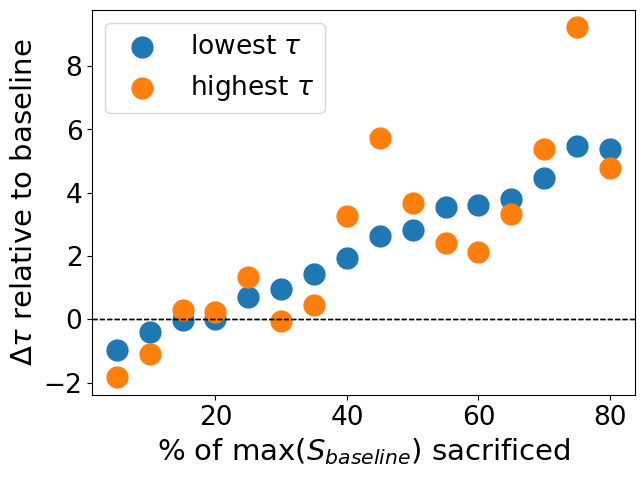

In [33]:
# Restrict the range of plotting to a desired q value
q_lim = 0.85
q_mask = q_vec <= q_lim 

fig, ax = plt.subplots(figsize=(7,5))

ax.scatter(q_vec[q_mask]*100, delta_taul_interp[q_mask], label=r'lowest $\tau$')
ax.axhline(0, ls='--', c='k', lw=1)

ax.scatter(q_vec[q_mask]*100, delta_tauh_interp[q_mask], label=r'highest $\tau$')
ax.axhline(0, ls='--', c='k', lw=1)

ax.set_xlabel(r'% of $\text{max}(S_{baseline})$ sacrificed')
ax.set_ylabel(r'$\Delta \tau$ relative to baseline')
ax.legend()
fig.savefig(fig_prefix + '/tau_minmax_shift.png', bbox_inches='tight')

#### 2nd attempt

In [ ]:
C = 9
assert np.any(np.isclose(C_vec/ncell_tot, C))
C_i = np.isclose(C_vec/ncell_tot, C).argmax()

# First, filter robustness values for this R value
rob_all_filtered = rob_all[:, 0, ...]

# Unravel the filtered robustness values into y_obs
y_obs = rob_all_filtered.ravel()

# Place the corresponding decision parameter values into x_obs
indices = np.unravel_index(np.arange(y_obs.size), rob_all_filtered.shape)
x_obs = np.full((y_obs.size, len(rob_all_filtered.shape)), np.nan)
x_obs[:, 0] = rob_thresh_vec[indices[0]]
x_obs[:, 1] = ncell_vec[indices[1]]
x_obs[:, 2] = slice_left_all[indices[2]]

# Filter out any invalid param combinations from both x and y
nan_filt = np.isnan(y_obs)
# y_obs = y_obs[~nan_filt]
# x_obs = x_obs[~nan_filt, :]
'''Instead try putting zeros in y_obs for nan'''
y_obs[nan_filt] = 0.0

# Rescale the y values (i.e. the robustness values)
y_rescaler = Rescaler(y_obs.min(axis=0), y_obs.max(axis=0))
y_obs = y_rescaler.rescale(y_obs) 
    
# Rescale the x values (i.e. the decision parameters)
x_rescaler = Rescaler(x_obs.min(axis=0), x_obs.max(axis=0))
x_obs = x_rescaler.rescale(x_obs)

In [ ]:
from scipy.interpolate import RBFInterpolator
interp = RBFInterpolator(x_obs, y_obs, neighbors=150, smoothing=0.05)

In [ ]:
# Check the interpolation at a given S^* value
Sstar_i = 70
vmin = np.nanmin(rob_all_filtered[Sstar_i])
vmax = np.nanmax(rob_all_filtered[Sstar_i])
plt.imshow(rob_all_filtered[Sstar_i], vmin=vmin, vmax=vmax, origin='lower')
plt.show()

unraveled_indices = np.unravel_index(np.arange(rob_all_filtered[Sstar_i].size), rob_all_filtered.shape[1:])
n_values = ncell_vec[unraveled_indices[0]]
l_values = slice_left_all[unraveled_indices[1]]
x_test = np.full((rob_all_filtered[Sstar_i].size, 3), np.nan)
x_test[:, 0] = rob_thresh_vec[Sstar_i]
x_test[:, 1] = n_values
x_test[:, 2] = l_values
x_test = x_rescaler.rescale(x_test)

y_test = interp(x_test)
y_test = y_rescaler.descale(y_test)
y_imshow = y_test.reshape((rob_all_filtered[Sstar_i].shape))
plt.imshow(y_imshow, vmin=vmin, vmax=vmax, origin='lower')
plt.show()

new_nan_filt = np.isnan(rob_all_filtered[Sstar_i].ravel())
print(f'raw data (min, max)=({vmin, vmax})')
interp_min, interp_max = (np.min(y_test[~new_nan_filt]), np.max(y_test[~new_nan_filt]))
print(f'interp data (min, max)=({interp_min, interp_max})')

In [ ]:
# Get parameters and S values under baseline condintions
C_mask = (x_all[:, 0] == (C*ncell_tot))
baseline_mask = np.all(x_all[:, 3:] == 0, axis=1)
x_obs_baseline = x_all[C_mask & baseline_mask, 1:3]
y_obs_baseline = meta_metric_all[C_mask & baseline_mask]

# Rescale inputs and outputs
x_rescaler_baseline = Rescaler(x_obs_baseline.min(axis=0), x_obs_baseline.max(axis=0))
x_obs_baseline = x_rescaler_baseline.rescale(x_obs_baseline)
y_rescaler_baseline = Rescaler(y_obs_baseline.min(axis=0), y_obs_baseline.max(axis=0))
y_obs_baseline = y_rescaler_baseline.rescale(y_obs_baseline) 

# Interpolate S(n, l) given R under baseline conditions for reference during optimization
interp_baseline = RBFInterpolator(x_obs_baseline, y_obs_baseline, neighbors=100, smoothing=0.05)

In [ ]:
from scipy.optimize import minimize

# Define objective function (i.e. robustness) to be optimized
def objective(decision_params, *args):
    Sstar = args[0]
    
    S_baseline = interp_baseline([decision_params])
    if S_baseline < Sstar:
        # Only consider robustness to be nonzero if S^* met under baseline
        robustness = 0
    else:
        # Take robustness value from interpolation
        x = np.full(len(decision_params)+1, np.nan)
        x[0] = Sstar
        x[1:] = decision_params
        robustness = interp([x])
    
    return -robustness # Negate bc using minimization algorithm

# Now step through S^* values and find decisions that optimize robustness
# for Sstar_i, Sstar in enumerate(rob_thresh_vec):
for Sstar_i, Sstar in zip([Sstar_i], [rob_thresh_vec[Sstar_i]]):
    # Use optimal decision from exisiting samples as starting point
    x0_position = np.nanargmax(rob_all_filtered[Sstar_i, :])
    n0_i, l0_i = np.unravel_index(x0_position, rob_all_filtered.shape[1:])
    n0, l0 = (ncell_vec[n0_i], slice_left_all[l0_i])
    
    # Rescale to interpolation scale
    Sstar, n0, l0 = x_rescaler.rescale([Sstar, n0, l0])

    # Use an optimizer that can handle some noise in the objective
    x0 = np.array([n0, l0])
    bounds = ((0, 1), (0, 1)) # Remeber, we rescaled the training data
    cons = [{'type': 'ineq', 'fun': lambda x:  1 - x[1] - x[0]}] # Constrain l < (n_tot - n)
    res = minimize(objective, x0, args=(Sstar), method='COBYLA', bounds=bounds, constraints=cons)

In [ ]:
print(f'original optimum of {np.nanmax(rob_all_filtered[Sstar_i])} at {x_rescaler.descale([Sstar_i, x0[0], x0[1]])}')
print(f'interpolated optimum of {y_rescaler.descale(-res.fun)} at {x_rescaler.descale([Sstar_i, res.x[0], res.x[1]])}')
res

In [ ]:
vmin = np.nanmin(rob_all_filtered[Sstar_i])
vmax = np.nanmax(rob_all_filtered[Sstar_i])
plt.imshow(rob_all_filtered[Sstar_i], vmin=vmin, vmax=vmax, origin='lower')

descaled_orignal = x_rescaler.descale([Sstar_i, x0[0], x0[1]])[1:]
descaled_interp = x_rescaler.descale([Sstar_i, res.x[0], res.x[1]])[1:]
labels = ['raw', 'interpolated']
for i, [n_opt, l_opt] in enumerate([descaled_orignal, descaled_interp]):
    # min + (i / length) * (max - min) = (value at i); solve for i
    n_opt_i = (n_opt - x_rescaler.mins[1]) * (len(ncell_vec) / (x_rescaler.maxes[1] - x_rescaler.mins[1]))
    l_opt_i = (l_opt - x_rescaler.mins[2]) * (len(slice_left_all) / (x_rescaler.maxes[2] - x_rescaler.mins[2]))
    plt.scatter(l_opt_i, n_opt_i, marker='x', s=120, linewidths=2.2, label=labels[i])
plt.legend()
plt.show()

plt.imshow(y_imshow, vmin=vmin, vmax=vmax, origin='lower')
for i, [n_opt, l_opt] in enumerate([descaled_orignal, descaled_interp]):
    # min + (i / length) * (max - min) = (value at i); solve for i
    n_opt_i = (n_opt - x_rescaler.mins[1]) * (len(ncell_vec) / (x_rescaler.maxes[1] - x_rescaler.mins[1]))
    l_opt_i = (l_opt - x_rescaler.mins[2]) * (len(slice_left_all) / (x_rescaler.maxes[2] - x_rescaler.mins[2]))
    plt.scatter(l_opt_i, n_opt_i, marker='x', s=120, linewidths=2.2, label=labels[i])
plt.show()

#### 1st attempt (by way of $S(R, n, l, ...)$)

In [ ]:
# from scipy.interpolate import RBFInterpolator
from sklearn.neighbors import KNeighborsRegressor
# import faiss

C = 9
assert np.any(np.isclose(C_vec/ncell_tot, C))
C_i = np.isclose(C_vec/ncell_tot, C).argmax()

# Filter parameter and metric metric values into xobs and yobs, respectively
indices = np.nonzero(x_all[:, 0] == (C*ncell_tot))[0]
x_obs = x_all[indices, 1:]
y_obs = meta_metric_all[indices]

# Class to rescale inputs and outputs to [0,1] for numerical stability
# Also store descalers to interpret interpolated values
class Rescaler:
    def __init__(self, mins, maxes):
        """
        mins: vector of minima
        maxes: vector of maxima
        """
        self.mins = mins
        self.maxes = maxes

    def rescale(self, x):
        return (x - self.mins) / (self.maxes - self.mins)
    
    def descale(self, x):
        return (x * (self.maxes - self.mins)) + self.mins
    
x_rescaler = Rescaler(x_obs.min(axis=0), x_obs.max(axis=0))
x_obs = x_rescaler.rescale(x_obs)

y_rescaler = Rescaler(y_obs.min(), y_obs.max())
y_obs = y_rescaler.rescale(y_obs)

In [ ]:
# Create the interpolator
# interp = RBFInterpolator(x_obs, y_obs, neighbors=50)

interp = KNeighborsRegressor(n_neighbors=100, weights='distance', algorithm='auto', n_jobs=6)
interp.fit(x_obs, y_obs)

# d = x_obs.shape[1]
# index = faiss.IndexFlatL2(d)
# index.add(x_obs.astype('float32'))

In [ ]:
# Create a grid of uncertain param samples to evaluate robustness with
uncertain_params = ['mu_tau', 'sigm_tau', 'mu_tauc', 'sigm_tauc', 'demographic_index']
num_points = 6
linspaces = [np.linspace(0, 1, num_points) for _ in range(5)] # Still in rescaled space so all [0,1]
grid_arrays = np.meshgrid(*linspaces)
uncertainty_samples = np.vstack([array.ravel() for array in grid_arrays]).T

# Initialize set of full samples for which the decision parameters will be filled in
empty_samples = np.full((len(uncertainty_samples), 2), np.nan)
full_samples = np.column_stack((empty_samples, uncertainty_samples))

In [ ]:
# Evaluate at an example point
n = 0.5
l = 0.2

full_samples[:, 0] = n
full_samples[:, 1] = l

# interp(full_samples)

interp.predict(full_samples)

# k = 50  # Number of neighbors
# distances, indices = index.search(full_samples.astype('float32'), k)
# Y_neighbors = y_obs[indices]  # shape: (n_query, k)
# y_pred = Y_neighbors.mean(axis=1)  # shape: (n_query,)

In [ ]:
# Optimize at a particular S^* value
Sstar = 0.5


##### RBF example

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import RBFInterpolator
from scipy.stats.qmc import Halton

rng = np.random.default_rng()
xobs = 2*Halton(2, seed=rng).random(100) - 1
yobs = np.sum(xobs, axis=1)*np.exp(-6*np.sum(xobs**2, axis=1))

xgrid = np.mgrid[-1:1:50j, -1:1:50j]
xflat = xgrid.reshape(2, -1).T
yflat = RBFInterpolator(xobs, yobs)(xflat)
ygrid = yflat.reshape(50, 50)

fig, ax = plt.subplots()
ax.pcolormesh(*xgrid, ygrid, vmin=-0.25, vmax=0.25, shading='gouraud')
p = ax.scatter(*xobs.T, c=yobs, s=50, ec='k', vmin=-0.25, vmax=0.25)
fig.colorbar(p)
plt.show()